In [2]:
! pip install gensim

  Obtaining dependency information for gensim from https://files.pythonhosted.org/packages/de/63/776ee55c773f55fa9d4fc1596f2e5e15de109921a6727dfe29cc4f0baeb7/gensim-4.3.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for scipy<1.14.0,>=1.7.0 from https://files.pythonhosted.org/packages/a3/ba/7255e5dc82a65adbe83771c72f384d99c43063648456796436c9a5585ec3/scipy-1.13.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 394.0 kB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for smart-open>=1.8.1 from https://files.pythonhosted.org/packages/06/bc/706838af28a542458bffe74a5d0772ca7f207b5495cd9fccfce61ef71f2a/smart_open-7.0.5-py3-none-any.whl.metadata
  Obtaining dependency information for wrapt from https://files.pythonhosted.org/packages/49/83/b40bc1ad04a868b5b5bcec86349f06c1ee1ea7afe51dc3e46131e4f39308/wrapt-1.16.0-cp310-cp310-manylinux_2_5_x86_64.man

In [4]:
! pip install pyldavis

  Obtaining dependency information for pyldavis from https://files.pythonhosted.org/packages/6b/5a/66364c6799f2362bfb9b7100bc1ce6ffcdfe7f17e8d2e85a591bfe427643/pyLDAvis-3.4.1-py3-none-any.whl.metadata
  Obtaining dependency information for numexpr from https://files.pythonhosted.org/packages/0e/e2/f07ab8322b1cd207e562b417c746fb006367f190955ba1dbf17981bcfcd9/numexpr-2.10.1-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for funcy from https://files.pythonhosted.org/packages/d5/08/c2409cb01d5368dcfedcbaffa7d044cc8957d57a9d0855244a5eb4709d30/funcy-2.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 3.2 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.0/405.0 kB 26.1 MB/s eta 0:00:00


In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from kiwipiepy import Kiwi
from tqdm import tqdm
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [17]:
# df = pd.read_csv("/data/ephemeral/home/yujin/processed_train_4220.csv")
df = pd.read_csv("/data/ephemeral/home/nick/level2-nlp-datacentric-nlp-10/new_labeled_dataset.csv")

df = df.dropna(subset=['text'])

In [18]:
kiwi = Kiwi()


- 명사 : NNG(일반명사), NNP(고유명사), NNB(의존명사)
- 동사 : VV
- 형용사 : VA, VX
- 어근 : XR
- 부호, 외국어, 특수문자 : SL(외국어), SN(한자), SN


- 한자는 음차 표기해도 좋지 않을까?

In [32]:
# 텍스트를 형태소 단위로 나누고 필요한 품사만 필터링
def preprocess_text(text):
    tokens = kiwi.tokenize(text)
    #filtered_tokens = [token.form for token in tokens if token.tag in ['NNG', 'NNP', 'VV', 'VA', 'XR']]
    filtered_tokens = [token.form for token in tokens if token.tag in ['NNG', 'NNP']  and len(token.form) >= 2]

    # # 영어 토큰화
    # english_tokens = word_tokenize(text)  # NLTK를 사용하여 영어 단어 토큰화
    # # 영어 단어는 필요에 따라 추가적인 필터링을 할 수 있습니다. 예: 영문 단어 길이가 1 이상인 경우
    # english_tokens = [word for word in english_tokens if len(word) > 1]
    
    # # 한국어와 영어 토큰 결합
    # combined_tokens = filtered_tokens + english_tokens
    # return ' '.join(combined_tokens)
    return ' '.join(filtered_tokens)

# 전체 데이터에 대해 전처리 적용
df['processed_text'] = df['text'].apply(preprocess_text)
df = df[df['processed_text'].apply(lambda x: len(x.split()) > 2)]
df.head()

,ID,text,target,processed_text,topic
0,ynat-v1_train_00003,갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩,4,갤노트8 주말 개통 시장 불법 보조금 얼룩,5
2,ynat-v1_train_00006,프로야구~롯TKIAs광주 경기 y천취소,1,프로 야구 광주 경기 취소,0
3,ynat-v1_train_00008,朴대통령 얼마나 많이 놀라셨어요…경주 지진현장 방문종합,6,대통령 경주 지진 현장 방문 종합,2
4,ynat-v1_train_00009,듀얼심 아이폰 하반기 출시설 솔솔…알뜰폰 기대감,4,듀얼 아이폰 하반기 출시 알뜰 기대감,5
5,ynat-v1_train_00011,NH투자 1월 옵션 만기일 매도 우세,5,투자 옵션 만기일 매도 우세,1


In [33]:
# 한국어 stop words 리스트 설정 (예시)
korean_stopwords = [
    '을', '를', '는', '에', '의', '다', '있다', '하다', 
    '그', '저', '그들', '저희', '이런', '어떤', '모든', '자신', '지금', 
    '또', '이렇게', '그런', '그리고', '하지만', '그러나', '또한', '때문에'
]

# CountVectorizer로 텍스트를 벡터화
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=korean_stopwords)
dtm = vectorizer.fit_transform(df['processed_text'])

In [34]:
# LDA 모델 학습
num_topics = 7  # 주제의 개수를 설정 (예: 카테고리가 7개인 경우)
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(dtm)

LatentDirichletAllocation(n_components=7, random_state=42)

In [35]:
# 각 문서에 대해 주제 확률 추출
df['topic'] = lda_model.transform(dtm).argmax(axis=1)


# 결과 확인
df

,ID,text,target,processed_text,topic
0,ynat-v1_train_00003,갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩,4,갤노트8 주말 개통 시장 불법 보조금 얼룩,1
2,ynat-v1_train_00006,프로야구~롯TKIAs광주 경기 y천취소,1,프로 야구 광주 경기 취소,6
3,ynat-v1_train_00008,朴대통령 얼마나 많이 놀라셨어요…경주 지진현장 방문종합,6,대통령 경주 지진 현장 방문 종합,2
4,ynat-v1_train_00009,듀얼심 아이폰 하반기 출시설 솔솔…알뜰폰 기대감,4,듀얼 아이폰 하반기 출시 알뜰 기대감,0
5,ynat-v1_train_00011,NH투자 1월 옵션 만기일 매도 우세,5,투자 옵션 만기일 매도 우세,6
...,...,...,...,...,...
1291,ynat-v1_train_02794,문 대통령 김기식 금감원장 사표 수리키로종합,2,대통령 김기식 금감원장 사표 수리 종합,1
1292,ynat-v1_train_02795,트럼프 폭스뉴스 앵커들 충성도 점수매겨…10점만점에 12점도,6,트럼프 폭스뉴스 앵커 충성도 점수 만점,1
1293,ynat-v1_train_02796,삼성 갤럭시S9 정식 출시 첫 주말 이통시장 잠잠,4,삼성 갤럭시S 정식 출시 주말 이통 시장,3
1294,ynat-v1_train_02798,인터뷰 류현진 친구에게 안타 맞는 것 싫어해…승부는 냉정,1,인터뷰 류현진 친구 안타 승부 냉정,4


In [37]:

documents = df['processed_text']

# TfidfVectorizer 사용하여 문서-단어 행렬 생성
vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(documents)

# LDA 모델 학습
num_topics = 7
lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=100, random_state=42)
lda_model.fit(dtm)
# 각 문서에 대해 주제 확률 추출
df['topic'] = lda_model.transform(dtm).argmax(axis=1)


# 결과 확인
df

,ID,text,target,processed_text,topic
0,ynat-v1_train_00003,갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩,4,갤노트8 주말 개통 시장 불법 보조금 얼룩,1
2,ynat-v1_train_00006,프로야구~롯TKIAs광주 경기 y천취소,1,프로 야구 광주 경기 취소,6
3,ynat-v1_train_00008,朴대통령 얼마나 많이 놀라셨어요…경주 지진현장 방문종합,6,대통령 경주 지진 현장 방문 종합,0
4,ynat-v1_train_00009,듀얼심 아이폰 하반기 출시설 솔솔…알뜰폰 기대감,4,듀얼 아이폰 하반기 출시 알뜰 기대감,4
5,ynat-v1_train_00011,NH투자 1월 옵션 만기일 매도 우세,5,투자 옵션 만기일 매도 우세,6
...,...,...,...,...,...
1291,ynat-v1_train_02794,문 대통령 김기식 금감원장 사표 수리키로종합,2,대통령 김기식 금감원장 사표 수리 종합,1
1292,ynat-v1_train_02795,트럼프 폭스뉴스 앵커들 충성도 점수매겨…10점만점에 12점도,6,트럼프 폭스뉴스 앵커 충성도 점수 만점,1
1293,ynat-v1_train_02796,삼성 갤럭시S9 정식 출시 첫 주말 이통시장 잠잠,4,삼성 갤럭시S 정식 출시 주말 이통 시장,3
1294,ynat-v1_train_02798,인터뷰 류현진 친구에게 안타 맞는 것 싫어해…승부는 냉정,1,인터뷰 류현진 친구 안타 승부 냉정,4


In [36]:
# 주제별 상위 단어 확인
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}: ", " ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

display_topics(lda_model, vectorizer.get_feature_names_out(), 10)

Topic 0:  종합 미국 교체 개발 특징 시장 출시 스마트폰 전환 경남
Topic 1:  종합 코스피 트럼프 내년 올해 상승 할인 여성 대통령 지원
Topic 2:  종합 대통령 로봇 언론 트럼프 내일 스마트 시위 이란 연구
Topic 3:  정상 회담 전국 평양 방송 남북 대통령 폭발 기자 게시판
Topic 4:  프로 개최 게시판 신간 올림픽 개발 대통령 농구 야구 운영
Topic 5:  대표 한국 감독 삼성 선수 연속 중국 축구 계약 영상
Topic 6:  투자 네이버 게시판 정보 주택 경기 가능 여행 평화 확대


In [38]:
# pyLDAvis 시각화
pyLDAvis.enable_notebook()

# 직접 LDA 결과를 시각화
panel = pyLDAvis.prepare(
    topic_term_dists=lda_model.components_ / lda_model.components_.sum(axis=1)[:, None],
    doc_topic_dists=lda_model.transform(dtm),
    doc_lengths=[len(doc.split()) for doc in df['processed_text']],
    vocab=vectorizer.get_feature_names_out(),
    term_frequency=dtm.sum(axis=0).getA1()
)
pyLDAvis.display(panel)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [12]:
! pip install bertopic transformers


  Obtaining dependency information for bertopic from https://files.pythonhosted.org/packages/95/5c/06feeb02dd288af34a46f3e8ac01d286d313ba902a048607f5bbed53a7db/bertopic-0.16.4-py3-none-any.whl.metadata
  Obtaining dependency information for hdbscan>=0.8.29 from https://files.pythonhosted.org/packages/53/f0/19fccde88302e2ba8bbf66b89b09d5fe0d94bc1c6760b3b9731d2c0573e5/hdbscan-0.8.39-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for plotly>=4.7.0 from https://files.pythonhosted.org/packages/e5/ae/580600f441f6fc05218bd6c9d5794f4aef072a7d9093b291f1c50a9db8bc/plotly-5.24.1-py3-none-any.whl.metadata
  Obtaining dependency information for sentence-transformers>=0.4.1 from https://files.pythonhosted.org/packages/45/18/1ec591befcbdb2c97192a40fbe7c43a8b8a8b3c89b1fa101d3eeed4d79a4/sentence_transformers-3.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for umap-learn>=0.5.0 from https://files.pythonhosted.org/packages/3c/8f/6

In [39]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# 데이터 준비
documents = df['processed_text'].tolist()

# BERTopic 모델 생성 및 학습
topic_model = BERTopic(language="multilingual")  # "multilingual"은 다양한 언어 텍스트에 맞춰 BERT를 설정합니다
topics, probs = topic_model.fit_transform(documents)

# 주제 정보 확인
topic_info = topic_model.get_topic_info()
print(topic_info)

# 특정 토픽의 상위 단어 출력
for topic_id in topic_info['Topic'].unique():
    print(f"Topic {topic_id}: {topic_model.get_topic(topic_id)}")


    Topic  Count                Name  \
0      -1    564      -1_종합_홍콩_경찰_대표   
1       0    116      0_게시판_개발_연구_기술   
2       1     85       1_대출_투자_할인_주택   
3       2     65      2_선거_대통령_정치_희망   
4       3     59       3_한국_북한_충북_최저   
5       4     57    4_삼성_스마트폰_아이폰_출시   
6       5     49       5_상장_특징_감독_교황   
7       6     37       6_강원_종합_주말_여행   
8       7     31  7_이스라엘_시리아_이란_에르도안   
9       8     23       8_야구_프로_홈런_기록   
10      9     20   9_김정은_김기식_금감원장_사표   
11     10     20      10_회담_정상_평양_남북   
12     11     17      11_신간_지방_생각_인사   
13     12     15      12_우주_드론_착륙_위성   
14     13     14    13_교양_경남_페스티벌_파랑   
15     14     13      14_라인_미세_먼지_위조   
16     15     13    15_참모_강형철_틀리프_트럼   
17     16     13      16_전국_날씨_구름_아침   
18     17     10    17_프랑스_난민_이민자_불법   
19     18     10     18_만화_미술_아트_박물관   

                                       Representation  \
0         [종합, 홍콩, 경찰, 대표, 류현진, 개최, 축구, 여성, 대통령, 네이버]   
1          [게시판, 개발, 연구, 기술, 기반, 사업, 통신, 기자, 

In [40]:
print(documents)

['갤노트8 주말 개통 시장 불법 보조금 얼룩', '프로 야구 광주 경기 취소', '대통령 경주 지진 현장 방문 종합', '듀얼 아이폰 하반기 출시 알뜰 기대감', '투자 옵션 만기일 매도 우세', '총리 부처 비상 대비 태세 강구', '게시판 박민정 책임 연구원 이사 선출', '공사 업체 협박 분쟁 해결 명목 언론인 집행유예', '월세 전환 주거비 부담 작년 역대 최고', '페이스북 인터넷 드론 아퀴 실물 시험 비행 성공', '해외로밍 폭탄 차단', '석면 규정 지키5', '안보리 대북 결의안 이행 보고서 제출 나라 육박', '게시판 코로나 일상 대국민 영상 공모', '크루즈 관광객 반나절 부산 해안 트레킹 상품 개발', '마틴 우리카드 코치 리그 복귀 한국', '씽큐 예파 디스플레이 무상 교체 혜택', '피폭 노동자 증언 후쿠시마 원전 은폐 속임수', '의장 창조 경제 논의', '한국 민족 뿌리 북방 한반도 자생 형성', '산업 생산 제조 가동 금융위', '근육 조직 생성 필수 열쇠 발견', '유엔 리비아 내전 악화 국제 확산 우려 아랍 연맹 긴급회의 종합', '공룡 파충 타조', '대한항공 우리카드 연승 GS칼텍스 라운드 전승 종합', '영상 선출 퇴장 나경원 원내 대표 파란만장', '류현진 특집 다큐 전설 류현진', '모바일 컴퓨팅 미래 서울 국제 학회 모비시스 개막', '영상 냄새 퇴근길', '대한항공 인천 바르셀로나 노선 취항', '태블릿 조작 변희재 징역 악의 공격 반복 종합', '성산 일출봉 주차장', '네이버 모바일 연예 콘텐츠 추천 시스템 적용', '증시 상품 국채선물 버스', '서울 문고 풍그 인수 라인 서점 영풍 양강', '대통령 호주 총리 축구 평가전 승부 축하', '운용 순위 인수 금융 펀드 결성 완료', '무수단 발사 대기 진입 기술 확보 여부 관건', '서방 백두산 연구 제의 과학 외교', '코스피 미국 악재 급락', '승리 박기원 감독 엔진', '프로 축구 부천 안산 승부', '지역 도시 난개발 개정안 발의', '아트 드라이빙 시

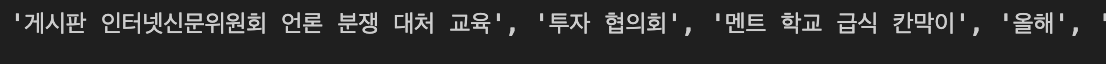

결국엔 corpus 안에 많은 word 가 있어야 클러스터링이 수월하지 않을까???

In [41]:

from sklearn.cluster import KMeans


# 1. **K-Means를 통한 BERTopic 모델 초기화**
# 원하는 토픽 수 설정
num_topics = 7

# K-Means 클러스터링 모델을 BERTopic에 전달하여 토픽 개수 고정
topic_model = BERTopic(hdbscan_model=KMeans(n_clusters=num_topics))

# 데이터 학습
topics, probs = topic_model.fit_transform(documents)

# 토픽 정보를 확인
print("K-Means로 설정된 토픽들:")
topic_info = topic_model.get_topic_info()
print(topic_info)

# 특정 토픽의 상위 단어 출력 (각 토픽의 상위 단어 확인)
for topic_id in topic_info['Topic'].unique():
    print(f"Topic {topic_id}: {topic_model.get_topic(topic_id)}")

K-Means로 설정된 토픽들:
   Topic  Count             Name  \
0      0    311   0_ibk_ok_sk_31   
1      1    253        1_lg_24__   
2      2    243      2_s9_g6_gs_   
3      3    165  3_u19_keb_kb_sk   
4      4    136   4_114_nh_cj_s8   
5      5    114     5_g20_fa_gs_   
6      6      9            6____   

                                 Representation  \
0  [ibk, ok, sk, 31, a8, h7n9, kgc, s8, kb, gs]   
1                      [lg, 24, , , , , , , , ]   
2                    [s9, g6, gs, , , , , , , ]   
3                [u19, keb, kb, sk, , , , , , ]   
4                 [114, nh, cj, s8, , , , , , ]   
5                   [g20, fa, gs, , , , , , , ]   
6                          [, , , , , , , , , ]   

                                 Representative_Docs  
0  [인공지능 기술 목소리 목소리 프로젝트, 푸틴 주석 러북 정상 회담 결과 설명 한반...  
1   [한국 디지털 뉴스 협회장 양상 한겨레 사장, 일왕 왕비 즉위 예식, 폭행 혐의 아스]  
2  [연휴 기간 통신사 작년 증가, G6 예약 판매 개시 액정 무상 수리 혜택, 배터리...  
3  [르포 궁극 화질 레드 라인 베일, 장마 전국 해수욕장 유명산 관광지, U19 축구...  
4  [단풍 오대

In [16]:

# 2. **Dynamic Topic Reduction을 이용하여 토픽 개수 조정**
# 초기 학습: 다수의 토픽을 생성하도록 설정
initial_topic_model = BERTopic(min_topic_size=2)  # min_topic_size는 최소 토픽 크기 설정
topics, probs = initial_topic_model.fit_transform(documents)

# 이후, reduce_topics를 사용하여 목표 토픽 수로 줄임
final_topic_model = initial_topic_model.reduce_topics(documents, nr_topics=num_topics)

# 줄여진 토픽 정보를 확인
print("\nDynamic Topic Reduction을 적용한 토픽들:")
reduced_topic_info = final_topic_model.get_topic_info()
print(reduced_topic_info)

# 줄여진 토픽에서 상위 단어 확인
for topic_id in reduced_topic_info['Topic'].unique():
    print(f"Topic {topic_id}: {final_topic_model.get_topic(topic_id)}")


Dynamic Topic Reduction을 적용한 토픽들:
   Topic  Count             Name                               Representation  \
0     -1    812  -1_gs_ibk_nh_sk  [gs, ibk, nh, sk, cj, fa, 114, 24, keb, s9]   
1      0   1615    0_sk_s8_kb_31   [sk, s8, kb, 31, ok, h7n9, fc, e2, a8, on]   
2      1    254        1_s7_s8__                     [s7, s8, , , , , , , , ]   
3      2     18            2____                         [, , , , , , , , , ]   
4      3      9        3_lg_s8__                     [lg, s8, , , , , , , , ]   
5      4      5            4____                         [, , , , , , , , , ]   
6      5      2            5____                         [, , , , , , , , , ]   

                                 Representative_Docs  
0  [트럼프 베트남 동맹 무기 무역 적자 불발 종, 서방 백두산 연구 제의 과학 외교 ...  
1  [청소년 괴롭힘 엄벌 강화 법률 고민, 터키 러시아 이튿날 공동 대 작전 러시아 체...  
2  [몸 크기 크 공룡 뿔 나 몸 많, 지난달 공시지가 분양 연속 증가, 1루 아키야마...  
3  [날씨 낮 강릉 일부 지역 대비 오늘 바람, 폭로전 삿대 고성 몸싸움 막장 바르 미...  
4  [LG전자 전기 차 맞먹 사양 강력 전소 전략, 게시판 LG유플러스 